<a href="https://colab.research.google.com/github/shanksghub/Minute-by-Minute-Price-prediction/blob/master/GRU%20edit%20this%20minute1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:




#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf




url1 = 'https://raw.githubusercontent.com/shanksghub/Minute-by-Minute-Price-prediction/master/IBM.1Min.TradesOnly.20160128.csv'


# import dataset 
a = pd.read_csv(url1)



a.head()
a =a.drop(columns=['Ticker','TimeBarStart','Date'])


In [45]:
a.head()

,FirstTradePrice,HighTradePrice,LowTradePrice,LastTradePrice,VolumeWeightPrice,Volume,TotalTrades
0,121.99,121.99,121.95,121.95,121.97000,64,2
1,121.00,121.78,121.00,121.78,121.37818,132,5
2,121.00,121.00,120.88,120.88,120.92000,273,4
3,120.88,120.88,120.88,120.88,120.88000,500,4
4,120.88,120.88,120.88,120.88,120.88000,3,1


In [0]:

# data scaling (normalizing)
def normalize_data(a):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a['FirstTradePrice'] = min_max_scaler.fit_transform(a.FirstTradePrice.values.reshape(-1,1))
    a['HighTradePrice'] = min_max_scaler.fit_transform(a.HighTradePrice.values.reshape(-1,1))
    a['LowTradePrice'] = min_max_scaler.fit_transform(a.LowTradePrice.values.reshape(-1,1))
    a['LastTradePrice'] = min_max_scaler.fit_transform(a['LastTradePrice'].values.reshape(-1,1))
    return a
a_norm = a.copy()
a_norm = normalize_data(a_norm)


In [0]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(a, seq_len):
    data_raw = a.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[1]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[1]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [49]:

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(a_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)



x_train.shape =  (388, 19, 7)
y_train.shape =  (388, 7)
x_valid.shape =  (2, 19, 7)
y_valid.shape =  (2, 7)
x_test.shape =  (2, 19, 7)
y_test.shape =  (2, 7)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [0]:

n_steps = seq_len-1 
n_inputs = 7
n_neurons = 2000
n_outputs = 7
n_layers = 20000
learning_rate = 0.001
batch_size = 5
n_epochs = 10
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [0]:


index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


In [0]:

#GRU 
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.relu)
          for layer in range(n_layers)] 

In [0]:
                                                                  
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]
                                              

In [0]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [56]:

                                              
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
            # Predictions
    y_test_pred = sess.run(outputs,feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 57020264.000000/13888928.000000
5.00 epochs: MSE train/valid = 45186940.000000/107795248.000000
10.00 epochs: MSE train/valid = 48138732.000000/42007204.000000
15.00 epochs: MSE train/valid = 44264324.000000/145185216.000000
20.00 epochs: MSE train/valid = 48018232.000000/163570608.000000
25.00 epochs: MSE train/valid = 48048220.000000/62790860.000000
30.00 epochs: MSE train/valid = 45954600.000000/83737640.000000
35.00 epochs: MSE train/valid = 44873956.000000/81669912.000000
40.00 epochs: MSE train/valid = 43872556.000000/170276304.000000
45.00 epochs: MSE train/valid = 44502540.000000/123532232.000000
50.00 epochs: MSE train/valid = 45897584.000000/269723552.000000
55.00 epochs: MSE train/valid = 45703240.000000/22463364.000000
60.00 epochs: MSE train/valid = 43998948.000000/48816544.000000
65.00 epochs: MSE train/valid = 43210512.000000/95348696.000000
70.00 epochs: MSE train/valid = 43634664.000000/82373136.000000
75.00 epochs: MSE train/valid = 4374

In [57]:

    
#checking prediction output nos 
y_test_pred.shape


(2, 7)

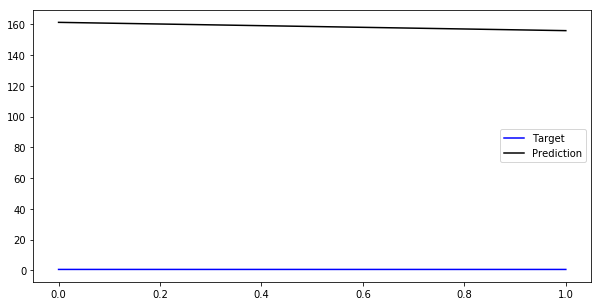

In [60]:

# ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,1],'Column3':y_test_pred[:,1]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column3'], color='black', label='Prediction')
plt.legend()
plt.show()